In [11]:
import sys
sys.path.append('..')
import h5py
import jax
import yaml
import matplotlib
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path
from scipy.interpolate import RBFInterpolator
from mpl_toolkits.axes_grid1 import ImageGrid

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation
from flowrec.utils.py_helper import slice_from_tuple

In [12]:
results_dir = Path('../local_results')
dt = 0.125 

# Get results

In [13]:
def interpolate(u,pb,case_observe,datacfg):

    take_observation, insert_observation = case_observe(datacfg, example_pred_snapshot=u[0,...],example_pin_snapshot=pb[0,...])
    observed = take_observation(u)
    temp_observed = np.empty_like(u)
    temp_observed.fill(np.nan) #this is noisy
    temp_observed = insert_observation(jnp.asarray(temp_observed),jnp.asarray(observed)) # observed_test is noisy if

    # get sensor coordinates
    sensors_empty = np.empty_like(u[[0],...])
    sensors_empty.fill(np.nan)

    grid_x,grid_y = np.mgrid[0:u[...,0].shape[1], 0:u[...,0].shape[2]]

    gridx1 = np.repeat(grid_x[None,:,:,None],3,axis=3)
    gridy1 = np.repeat(grid_y[None,:,:,None],3,axis=3)

    idx_x = take_observation(gridx1)
    idx_y = take_observation(gridy1)

    idx_x = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_x))[0,...]
    sensors_loc_x = []
    for i in range(idx_x.shape[-1]):
        sensors_loc_x.append(idx_x[...,i][~np.isnan(idx_x[...,i])])

    idx_y = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_y))[0,...]
    sensors_loc_y = []
    for i in range(idx_y.shape[-1]):
        sensors_loc_y.append(idx_y[...,i][~np.isnan(idx_y[...,i])])


    compare_interp = list([])
    nt = u.shape[0]
    _locs = np.stack((grid_x.flatten(),grid_y.flatten()),axis=-1)

    for i in range(3):
        sensors_loc = np.stack((sensors_loc_x[i].flatten(),sensors_loc_y[i].flatten()),axis=-1)
        for j in range(nt):
            temp_measurement = temp_observed[j,...,i][~np.isnan(temp_observed[j,...,i])]
            # print(sensors_loc.shape, temp_measurement.shape)
            rbf = RBFInterpolator(sensors_loc,temp_measurement.flatten(),kernel='thin_plate_spline')
            _interp = rbf(_locs).reshape(grid_x.shape)
            compare_interp.append(_interp)
    compare_interp = np.array(compare_interp)
    compare_interp = np.stack((compare_interp[:nt,...],compare_interp[nt:2*nt,...],compare_interp[2*nt:3*nt,...]),axis=-1)

    return compare_interp

In [14]:
def get_single_case_predictions(folder):
    with open(Path(folder,'config.yml'),'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
        cfg.data_config.data_dir = '.'+cfg.data_config.data_dir

    x_base = 132
    triangle_base_coords = [49,80]
    (ux,uy,pp) = simulation.read_data_2dtriangle(cfg.data_config.data_dir,x_base)
    x = np.stack([ux,uy,pp],axis=0)
    # remove parts where uz is not zero
    s = slice_from_tuple(cfg.data_config.slice_to_keep)
    x = x[s]

    [_,_,x_test], _ = data_utils.data_partition(x,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss

    [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

    datainfo = data_utils.DataMetadata(
        re = cfg.data_config.re,
        discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
        axis_index=[0,1,2],
        problem_2d=True
    ).to_named_tuple()

    u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)

    ## normalise
    if cfg.data_config.normalise:
        [ux_test_normal,uy_test_normal,pp_test_normal], test_minmax = data_utils.normalise(ux_test,uy_test,pp_test)
        ## take input
        pb_test = simulation.take_measurement_base(pp_test_normal,ly=triangle_base_coords,centrex=0)
    else:
        ## take input
        pb_test = simulation.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

    pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))
    
    
    ## predict
    state = state_utils.restore_trainingstate(folder,'state')
    _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
    mdl = make_model(cfg.model_config)
    # rng_mdl = jax.random.PRNGKey(10)
    pred_test = mdl.apply(state.params,None,pb_test,TRAINING=False)
    if cfg.data_config.normalise:
        pred_test = data_utils.unnormalise_group(pred_test, test_minmax, axis_data=-1, axis_range=0)

    interp_test = interpolate(u_test,pb_test,cfg.case.observe,cfg.data_config)

    return (u_test, interp_test, pred_test), datainfo

In [15]:
def get_summary(resulr_dir: Path):

    repeat_dir = resulr_dir.iterdir()
    loss = []
    loss_physics = []

    for folder in repeat_dir:
        (u_test, _, pred_test), datainfo = get_single_case_predictions(folder)
        rel_l2_pred = losses.relative_error(pred_test,u_test)
        loss.append(rel_l2_pred)

        # print(pred_test.shape)
        ldiv = losses.divergence(pred_test[...,:-1],datainfo)
        lmom = losses.momentum_loss(pred_test,datainfo)
        loss_physics.append(ldiv+lmom)
        
        print(f'Testing loss of run {str(folder)}: {rel_l2_pred}, physics loss: {ldiv+lmom}')

    return loss, loss_physics

In [19]:
loss_list_grid, loss_physics_grid = get_summary(Path(results_dir,'draft/clean_repeats/grid'))
loss_list_sparse, loss_physics_sparse= get_summary(Path(results_dir,'draft/clean_repeats/sparse'))

Testing loss of run ../local_results/draft/clean_repeats/grid/grid-59: 0.023799337446689606, physics loss: 0.028983118012547493
Testing loss of run ../local_results/draft/clean_repeats/grid/grid-43: 0.022915231063961983, physics loss: 0.05197092145681381
Testing loss of run ../local_results/draft/clean_repeats/grid/grid-642: 0.025914033874869347, physics loss: 0.054229769855737686
Testing loss of run ../local_results/draft/clean_repeats/grid/grid-7: 0.02467699721455574, physics loss: 0.03002210333943367
Testing loss of run ../local_results/draft/clean_repeats/grid/grid-83: 0.02539719268679619, physics loss: 0.03218993544578552
Testing loss of run ../local_results/draft/clean_repeats/sparse/sparsepod-83: 0.07694513350725174, physics loss: 0.004060899838805199
Testing loss of run ../local_results/draft/clean_repeats/sparse/sparsepod-43: 0.07863982021808624, physics loss: 0.005268298555165529
Testing loss of run ../local_results/draft/clean_repeats/sparse/sparsepod-59: 0.07829563319683075

In [20]:
print(f'Grid: mean is {np.mean(loss_list_grid)}, std is {np.std(loss_list_grid)}')
print(f'Sparse: mean is {np.mean(loss_list_sparse)}, std is {np.std(loss_list_sparse)}')
print('\n Physics loss:')
print(f'Grid: mean is {np.mean(loss_physics_grid)}, std is {np.std(loss_physics_grid)}')
print(f'Sparse: mean is {np.mean(loss_physics_sparse)}, std is {np.std(loss_physics_sparse)}')

Grid: mean is 0.024540558457374573, std is 0.0010798120638355613
Sparse: mean is 0.07956989109516144, std is 0.005295741371810436

 Physics loss:
Grid: mean is 0.03947916999459267, std is 0.011192499659955502
Sparse: mean is 0.006201471667736769, std is 0.002721597207710147


# Best run

In [21]:
# from_grid = Path(results_dir,'draft/t2gpfcpi3230714182415/')
# from_sparse = Path(results_dir,'t2spfcpi3230628162920/restart/') #max-min of first 2 pod modes and 4 boundary points
from_grid = Path(results_dir,'draft/clean_repeats/grid/grid-59')
from_sparse = Path(results_dir,'draft/clean_repeats/sparse/sparsepod-642') #max-min of first 2 pod modes and 4 boundary points

In [22]:
results_grid, datainfo_grid = get_single_case_predictions(from_grid)
results_sparse, datainfo_sparse = get_single_case_predictions(from_sparse)

# Make figures

## Instantaneous and mean flow 

In [23]:
def make_image_imshow(results,figname,t):
    
    error_pred = np.abs(results[0] - results[2])
    error_interp = np.abs(results[0] - results[1])
    
    fig = plt.figure(figsize=(8,6))
    grid1 = ImageGrid(fig,(0.08,0.62,0.92,0.28),(1,5),share_all=True,cbar_mode='each',axes_pad=(0.4,0.02),cbar_pad=0.01)
    grid2 = ImageGrid(fig,(0.08,0.32,0.92,0.28),(1,5),share_all=True,cbar_mode='each',axes_pad=(0.4,0.02),cbar_pad=0.01)
    grid3 = ImageGrid(fig,(0.08,0.02,0.92,0.28),(1,5),share_all=True,cbar_mode='each',axes_pad=(0.4,0.02),cbar_pad=0.01)

    axes = []
    cbar_axes = []
    axes.append(grid1.axes_all)
    cbar_axes.append(grid1.cbar_axes)
    axes.append(grid2.axes_all)
    cbar_axes.append(grid2.cbar_axes)
    axes.append(grid3.axes_all)
    cbar_axes.append(grid3.cbar_axes)

    for i in range(3):
        im_true = axes[i][0].imshow(results[0][t,:,:,i],extent=[-2,2,5.86,0])
        cbar = cbar_axes[i][0].colorbar(im_true)
        cbar.ax.tick_params(labelsize=9,length=2)
        axes[i][0].set(ylabel='$x_1$')

        im_interp = axes[i][1].imshow(results[1][t,:,:,i],extent=[-2,2,5.86,0])
        cbar = cbar_axes[i][1].colorbar(im_interp)
        cbar.ax.tick_params(labelsize=9,length=2)

        im_pred = axes[i][2].imshow(results[2][t,:,:,i],extent=[-2,2,5.86,0])
        cbar = cbar_axes[i][2].colorbar(im_pred)
        cbar.ax.tick_params(labelsize=9,length=2)

        im_errinterp = axes[i][3].imshow(error_interp[t,:,:,i],extent=[-2,2,5.86,0])
        cbar = cbar_axes[i][3].colorbar(im_errinterp)
        cbar.ax.tick_params(labelsize=9,length=2)

        im_errpred = axes[i][4].imshow(error_pred[t,:,:,i],extent=[-2,2,5.86,0])
        cbar = cbar_axes[i][4].colorbar(im_errpred)
        cbar.ax.tick_params(labelsize=9,length=2)

        for ax in axes[i]:
            ax.set(xticklabels=[],xticks=[],yticks=[],yticklabels=[])

    axes[2][0].set(xlabel='$x_2$')
    
    labels = ['True','Interpolated','Predicted','Absolute error\n intepolated','Absolute error\n predicted']
    for i in range(len(axes[0])):
        axes[0][i].set_title(labels[i])
    
    for i in range(3):
        [iminterp] = axes[i][3].get_images()
        [impred] = axes[i][4].get_images()
        climinterp = iminterp.get_clim()
        climpred = impred.get_clim()
        impred.set_clim(min(climpred[0],climinterp[0]),max(climpred[1],climinterp[1]))
        iminterp.set_clim(min(climpred[0],climinterp[0]),max(climpred[1],climinterp[1]))


    fig.text(0.02,0.16,'$p$',fontsize='large')
    fig.text(0.02,0.46,'$u_2$',fontsize='large')
    fig.text(0.02,0.76,'$u_1$',fontsize='large')

    fig.text(0.5,0.98,f'$t={t*dt}$',fontsize='x-large')

    # fig.savefig('./figs/'+figname,bbox_inches='tight')
    plt.show()

/home/ym917/anaconda3/envs/fr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


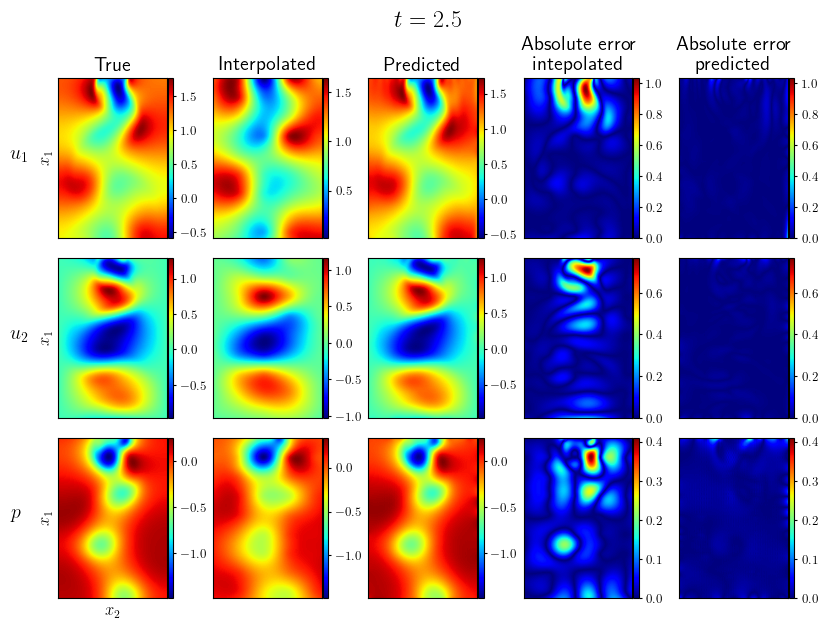

/home/ym917/anaconda3/envs/fr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


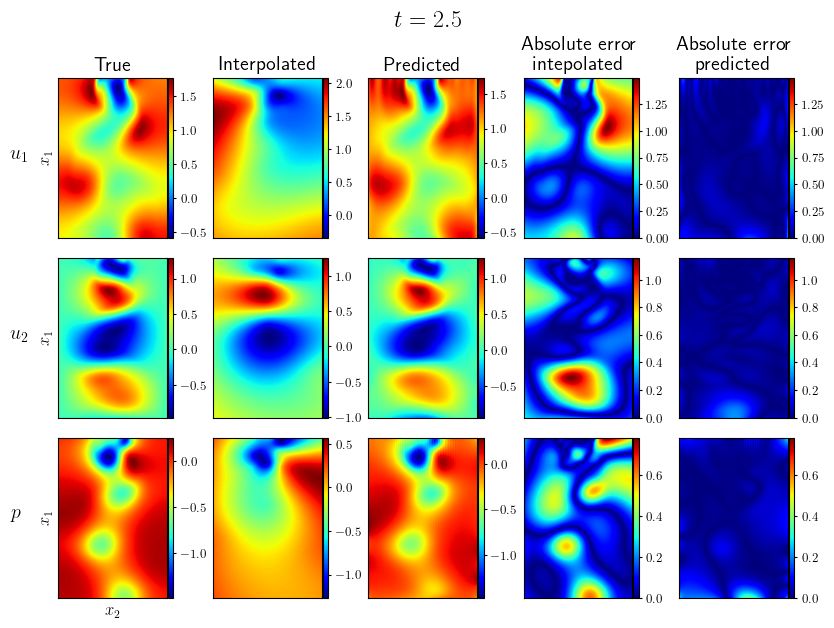

In [24]:
make_image_imshow(results_grid,'clean_grid_images',20)
make_image_imshow(results_sparse,'clean_sparse_images',20)

Probability density

In [41]:
def make_image_pdf(data,figname):

    ## interpolation
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[1][0,...,i])
        interp_test_nonan.append(data[1][...,i][:,mask])

    ## plot
    fig,axes = plt.subplots(1,3,figsize=(7,3))
    for i,var in zip(range(3),['$u_1^\prime$','$u_2^\prime$','$p^\prime$']):
        # true
        counts_true,bins_true = np.histogram(data[0][...,i].flatten()-np.mean(data[0][...,i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts_true,bins_true,label='True',linewidth=3, color='#808080',alpha=0.5)
        # interpolation
        counts,bins = np.histogram(interp_test_nonan[i].flatten()-np.mean(interp_test_nonan[i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts,bins,label='Interp.',color='k',linestyle='--')
        
        # prediction
        counts,bins = np.histogram(data[2][...,i].flatten()-np.mean(data[2][...,i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts,bins,label='Predicted')
        axes[i].set(xlabel=var)
    axes[0].set_ylabel('Probability density')

    handlers = axes[0].get_legend_handles_labels()
    fig.legend(*handlers,loc='upper center', bbox_to_anchor=(0.5, 1.15),ncols=5)

    plt.savefig('./figs/'+figname,bbox_inches='tight')
    # plt.show()


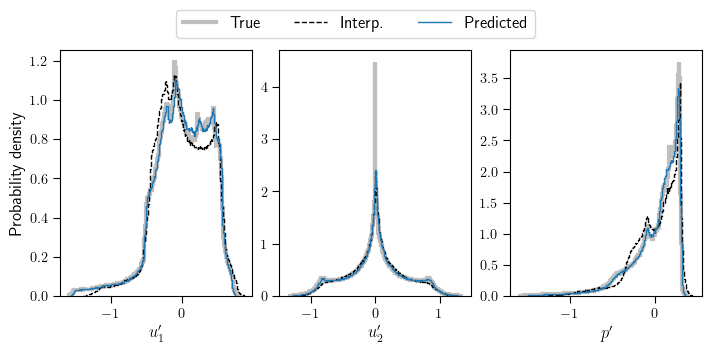

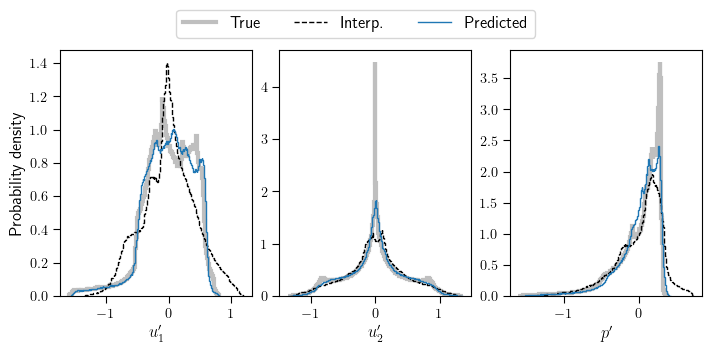

In [42]:
make_image_pdf(results_grid,'clean_grid_pdf')
make_image_pdf(results_sparse,'clean_sparse_pdf')

Frequency spectrum

In [43]:
var_names = ['$u_1^\prime$','$u_2^\prime$','$p^\prime$']

def make_image_freq(data, figname):

    n = np.prod(data[0].shape[1:-1])

    fftfreq = np.fft.fftfreq(data[0].shape[0],d = dt)
    midpoint = int(len(fftfreq)/2)
    
    # data
    f_data = np.einsum('t x y u -> t u', np.abs(np.fft.fft(data[0]-np.mean(data[0],axis=0),axis=0)))

    # interpolated
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[1][0,...,i])
        interp_test_nonan.append(data[1][...,i][:,mask])
    f_interp = []
    for i in range(3):
        _interp = np.einsum('t n -> t', np.abs(np.fft.fft(interp_test_nonan[i]-np.mean(interp_test_nonan[i]),axis=0)))
        # _interp = _interp / np.std(_interp)
        f_interp.append(_interp)


    fig, axes = plt.subplots(1,3,sharex=True,figsize=(7,3))
    for i in range(3):
        axes[i].plot(fftfreq[:midpoint], 2*f_data[:midpoint,i],label='True',linewidth=3,color='#808080',alpha=0.5)
        axes[i].plot(fftfreq[:midpoint], 2*f_interp[i][:midpoint],label='Interp',linewidth=1,color='k',linestyle='--')
        
        f_pred = np.einsum('t x y u -> t u', np.abs(np.fft.fft(data[2]-np.mean(data[2],axis=0),axis=0)))
        axes[i].plot(fftfreq[:midpoint], 2*f_pred[:midpoint,i],label='Predicted',linewidth=1)
        axes[i].set(xlabel='$Hz$',title=var_names[i])
        
    axes[0].set(ylabel='Magnitude', xlim=[0,4])
        

    handlers = axes[0].get_legend_handles_labels()
    fig.legend(*handlers,loc='upper center', bbox_to_anchor=(0.5, 1.15),ncols=5)
    plt.savefig('./figs/'+figname,bbox_inches='tight')

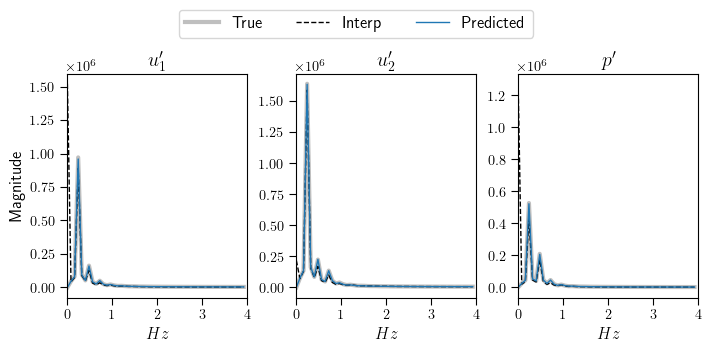

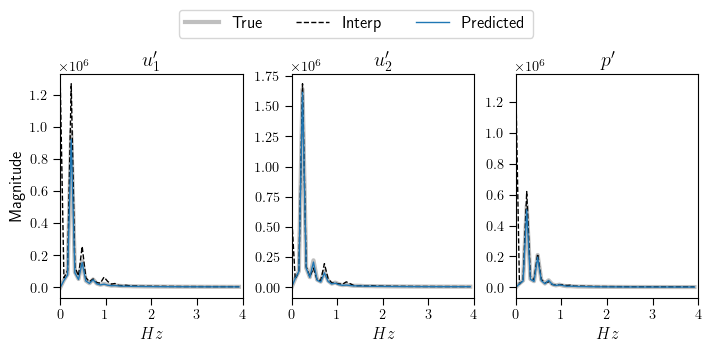

In [44]:
make_image_freq(results_grid,'clean_grid_freq')
make_image_freq(results_sparse,'clean_sparse_freq')

# Sensors

In [9]:
results_sparse[0].shape

(100, 250, 129, 3)

/tmp/ipykernel_23521/2523944990.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


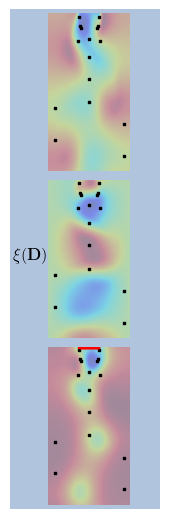

In [56]:
idx = [[44, 44, 23, 23, 140, 68, 40, 103, 5, 5, 20, 20, 150, 175, 200, 225],[81, 47, 51, 77, 64, 64, 64, 64, 80, 48, 78, 50, 10, 119, 10, 119]]
fig = plt.figure(figsize=(1.5,5))
sfig = fig.subfigures(1,1,facecolor='lightsteelblue')
subfigs = fig.subfigures(1,2,width_ratios=[0.05,0.9],wspace=-0.1,facecolor='lightsteelblue')
axes = subfigs[1].subplots(3,1)
for i in range(3):
    axes[i].imshow(results_sparse[0][0,:,:,i],alpha=0.3)
    axes[i].axis('off')
    axes[i].scatter(idx[1],idx[0],s=3,c='k',marker='s')
axes[2].scatter(range(49,80),[0]*31,marker='s',c='r',s=3)

subfigs[1].text(-0.032,0.5,'$\\xi(\mathbf{D})$')

# fig.savefig('./figs/data_taking_observations',bbox_inches='tight')

fig.show()

In [13]:
with open(Path(from_grid,'config.yml'),'r') as f:
    cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
    cfg.data_config.data_dir = '.'+cfg.data_config.data_dir
slice_grid_sensors = slice_from_tuple(cfg.data_config.slice_grid_sensors)
slice_inlet_sensors = slice_from_tuple(cfg.data_config.pressure_inlet_slice)

gridx, gridy = np.meshgrid(range(250),range(129))
grid_idx_y = gridx[slice_grid_sensors].flatten()
grid_idx_x = gridy[slice_grid_sensors].flatten()
input_idx_y = gridy[slice_inlet_sensors].flatten()
input_idx_x = gridx[slice_inlet_sensors].flatten()

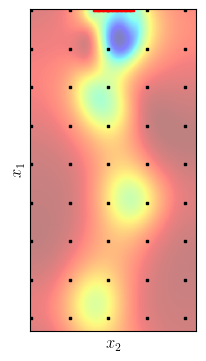

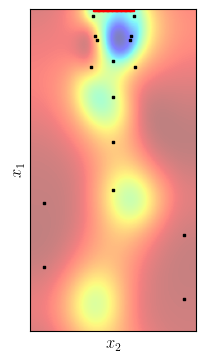

In [52]:
fig1,ax1 = plt.subplots(1,1,figsize=(2,3.5))
ax1.imshow(results_grid[0][0,:,:,2],alpha=0.5)
ax1.scatter(grid_idx_x,grid_idx_y,s=3,c='k',marker='s')
ax1.scatter(input_idx_x,input_idx_y,s=3,c='r',marker='s')

ax1.set_xlabel('$x_2$')
ax1.set_ylabel('$x_1$')
ax1.set_xticks([])
ax1.set_yticks([])

fig1.savefig('./figs/clean_sensor_loc_grid')


idx = [[44, 44, 23, 23, 140, 68, 40, 103, 5, 5, 20, 20, 150, 175, 200, 225],[81, 47, 51, 77, 64, 64, 64, 64, 80, 48, 78, 50, 10, 119, 10, 119]]
fig2,ax2 = plt.subplots(1,1,figsize=(2,3.5))

ax2.imshow(results_grid[0][0,:,:,2],alpha=0.5)
ax2.scatter(idx[1],idx[0],s=3,c='k',marker='s')
ax2.scatter(input_idx_x,input_idx_y,s=3,c='r',marker='s')

ax2.set_xlabel('$x_2$')
ax2.set_ylabel('$x_1$')
ax2.set_xticks([])
ax2.set_yticks([])

fig2.savefig('./figs/clean_sensor_loc_sparse')

plt.show()

In [53]:
loss_interp_grid = losses.relative_error(results_grid[1],results_grid[2])*100
loss_interp_sparse = losses.relative_error(results_sparse[1],results_sparse[2])*100

loss_physics_interp_grid = losses.divergence(results_grid[1][...,:-1],datainfo_grid) + losses.momentum_loss(results_grid[1],datainfo_grid)
loss_physics_interp_sparse = losses.divergence(results_sparse[1][...,:-1],datainfo_sparse) + losses.momentum_loss(results_sparse[1],datainfo_sparse)

print(f'Interpolated relative error(%) from grid sensors is {loss_interp_grid}')
print(f'Interpolated physics loss from grid sensors is {loss_physics_interp_grid}')
print(f'Interpolated relative error(%) from sparse sensors is {loss_interp_sparse}')
print(f'Interpolated physics loss from sparse sensors is {loss_physics_interp_sparse}')

Interpolated relative error(%) from grid sensors is 15.432961285114288
Interpolated physics loss from grid sensors is 0.30097419023513794
Interpolated relative error(%) from sparse sensors is 51.58170461654663
Interpolated physics loss from sparse sensors is 1.2960827350616455
